# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

## Examining Racial Discrimination in the US Job Market
* Background
    * Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

In [43]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set()

In [19]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [20]:
# number of callbacks for white-sounding names
sum(data[data.race=='w'].call)

235.0

In [8]:
data.info()
data.shape
data.describe()
data.head(5)

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

## Q1. What test is appropriate for this problem? Does CLT apply?
* Since we are checking if the mean call back rate between white sounding and black sounding names are differnet, the appropriate test here will be independent t-test.


* CLT Conditions ( Independent Samples Test ):
    1. “Randomization”: 
        * Each sample should represent a random sample from the population, or at least follow the population distribution.
    
    2. “10% Rule”: 
        * The sample size must not be bigger than 10% of the entire population. (If no bootstraping when sampling)

    3. Large Enough Sample Size ( a or b ): 
        * a. Sample size n should be large enough so that np≥10 and nq≥10
        * b. The sample size must be sufficiently large. In general a sample size of 30 is considered sufficient 


In [21]:
df = data[['race','call']]
black = df[df.race == "b"]
white = df[df.race == 'w']

sample_pop_ratio = len(df) / 143357000
if sample_pop_ratio < 0.1:
    print("sample population ration meet the CLT condition 2")
else:
    print("sample population ratio did not meet the CLT condition 2")


p_for_black = np.sum(black.call) / len(black.call)
q_for_black = 1 - p_for_black
p_for_white = np.sum(white.call) / len(white.call)
q_for_white = 1 - p_for_white

print("np and nq for black: " + str(len(black) * p_for_black), str(len(black) * q_for_black))
print("np and nq for white: " + str(len(white) * p_for_white), str(len(white) * q_for_white))

sample population ration meet the CLT condition 2
np and nq for black: 157.0 2278.0
np and nq for white: 235.0 2200.0


#### CLT conditions met

## Q2. What are the null and alternate hypotheses?
* H0: mean of white sounding names call back rate = mean of black sounding names call back rate
* H1: mean of white sounding names call back rate ≠ mean of black sounding names call back rate

## Q3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

* Bootstrap ( two - tail ) :
    * H0: mean of white sounding names call back rate = mean of black sounding names call back rate ( mean of black sounding names - mean of white sounding names = 0 )
    * H1: mean of white sounding names call back rate ≠ mean of black sounding names call back rate ( mean of black sounding names - mean of white sounding names ≠ 0 )

In [47]:
# To draw a bootstrap replicate:
def bs_replicate_for_1D(data, func):
    return func(np.random.choice(data, size=len(data)))

# To draw n bootstrap replicates:
def draw_bs_replicates(data, func, size):
    
    bs_replicates = np.empty(shape=size)
    
    for i in range(size):
        bs_replicates[i] = bs_replicate_for_1D(data, func)
        
    return bs_replicates

# Draw 10000 for black sounding name call back:
blk_10k = draw_bs_replicates(black.call, np.mean, 10000)
print('mean of black call back rate: '+ str(np.mean(blk_10k)))
print('stadard deviation of black call back rate: ' + str(np.std(blk_10k)))

wt_10k = draw_bs_replicates(white.call, np.mean, 10000)
print('mean of white call back rate: '+ str(np.mean(wt_10k)))
print('stadard deviation of black call back rate: '+ str(np.std(wt_10k)))

z_value = stats.norm.ppf(q=0.975)

standard_error = z_value * (math.sqrt((((len(black.call)-1) * 0.004958279078867816) + ((len(white.call) - 1) * 0.006021424818473383)) / (len(df)))) * math.sqrt(1 / len(black.call) + 1 / len(white.call))
mean_diff = np.mean(wt_10k) - np.mean(blk_10k)

print("95% CI: " + str(mean_diff - standard_error) + ', ' + str(mean_diff + standard_error))

mean of black call back rate: 0.06438234075382351
stadard deviation of black call back rate: 0.004943340034257509
mean of white call back rate: 0.09651252567917108
stadard deviation of black call back rate: 0.0059775271697761175
95% CI: 0.02796911775495794, 0.0362912520957372


#### We can tell from the 95% confidence interval that the mean difference is not equal to 0, we can reject the null hypothesis that mean of white call back rate = black call back rate

* Frequentist statistical:
    * H0: mean of white sounding names call back rate = mean of black sounding names call back rate
    * H1: mean of white sounding names call back rate ≠ mean of black sounding names call back rate

In [48]:
print(np.var(black.call))
print(np.var(white.call))

0.060318876057863235
0.08719314634799957


#### Since the variances of the two groups are different from each other, we are going to use Welch t Test statistic here instead of independent t-test

In [49]:
t_test = stats.ttest_ind(black.call, white.call, axis=0, equal_var=False)
print("t-score: "'{0:.20f}'.format(t_test.statistic))
print("t-test p-value: "'{0:.20f}'.format(t_test.pvalue))

t-score: -4.11470529086175140776
t-test p-value: 0.00003942941513645935


#### SInce the p-value is significantly small, we can reject the null hypothesis and accept the alternative which the mean call back rate of white sounding name is different to mean call back rate of black sounding name

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

## Q4. Write a story describing the statistical significance in the context or the original problem.

#### The purpose of this research is to find if discrimination exist in US job market between blacks and whites, data are collected by randomly assigning identical résumés black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

#### By performing some statistic test, I realized that the difference of call back rate between white-sounding name and black-sounding name are significant, which white-sounding name get 50% more call for interview than black-sounding name.

#### The result indicates that all other things being same, the white-sounding name have a 50% higher call back rate for  interview than black-sounding name, discrimination betweenblacks and whites do exist in the US job market between 2000 - 2002

## Q5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

#### Our analysis can only tell us that there exist a callback rate different between blacks and whites, but we cannot conclude that this is the most important factor, since this is the only factor we check.

#### There still exist other 63 columns for us to pick from, which we can check their relationship with call back rate, for example: sex, yearsexp, etc, which I am going to perform below

## Xtra 1: sex and callback rate

In [54]:
df_sex = data[['call','sex']]
df_sex.head()
male = df_sex[df_sex.sex=='m']
female = df_sex[df_sex.sex=='f']
print("Male call back rate: " + str(np.mean(male.call)))
print("Female call back rate: " + str(np.mean(female.call)))
print(stats.ttest_ind(male.call, female.call, axis=0, equal_var=False))

Male call back rate: 0.07384341955184937
Female call back rate: 0.08248798549175262
Ttest_indResult(statistic=-0.9598607875589354, pvalue=0.3372456192523712)


#### At the 5% significant level, we cannot reject the null hypothesis that mean male call back rate is different from mean female call back rate

## Xtra 2: education and callback rate

In [55]:
df_exp = data[['yearsexp','call']]
df_exp.head()

ten_yrs_plus_exp = df_exp[df_exp.yearsexp > 10]
less_exp = df_exp[df_exp.yearsexp <= 10]

print("Call back rate for people that have more than 10 years expereince: " + str(np.mean(ten_yrs_plus_exp.call)))
print("Call back rate for people that have less than 10 years expereince: " + str(np.mean(less_exp.call)))

print(stats.ttest_ind(ten_yrs_plus_exp.call, less_exp.call, axis=0, equal_var=False))


Call back rate for people that have more than 10 years expereince: 0.11386138945817947
Call back rate for people that have less than 10 years expereince: 0.07176166027784348
Ttest_indResult(statistic=3.8878297098233277, pvalue=0.00010596206219926696)



#### From the result of the t-test, we can reject the null hypothesis, and accpet the alterncativethat the call back rate for people with more than 10 years exp is higher than those who have less than 10 years exp.

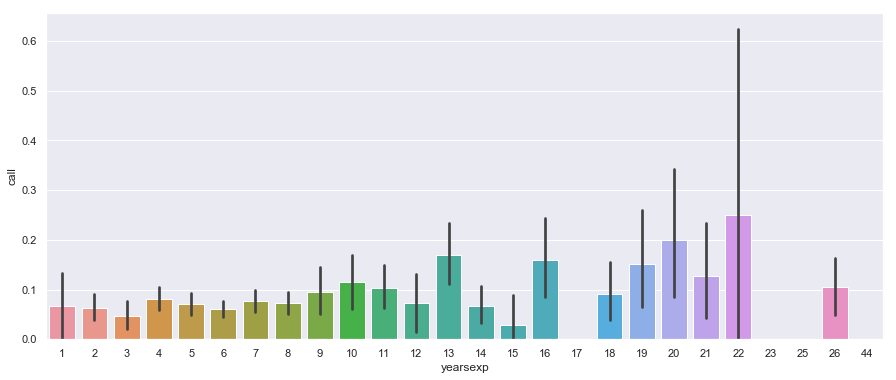

In [70]:
sns.barplot(x=df_exp.yearsexp, y=df_exp.call)
sns.set(rc={'figure.figsize':(15,4)})

#### The result of the barplot is pretty obvious that years of experience is one of other significant factor that will affect the call back rate